In [1]:
import pandas as pd
penguins = pd.read_csv('penguins.csv')
penguins.dropna(inplace=True)
penguins

,CulmenLength,CulmenDepth,FlipperLength,BodyMass,Species
0,39.1,18.7,181.0,3750.0,0
1,39.5,17.4,186.0,3800.0,0
2,40.3,18.0,195.0,3250.0,0
4,36.7,19.3,193.0,3450.0,0
5,39.3,20.6,190.0,3650.0,0
...,...,...,...,...,...
339,55.8,19.8,207.0,4000.0,2
340,43.5,18.1,202.0,3400.0,2
341,49.6,18.2,193.0,3775.0,2
342,50.8,19.0,210.0,4100.0,2


In [2]:
penguins['Species'].nunique()

3

In [3]:
features = ['CulmenLength','CulmenDepth','FlipperLength','BodyMass']
target = 'Species'

Unique values: 164


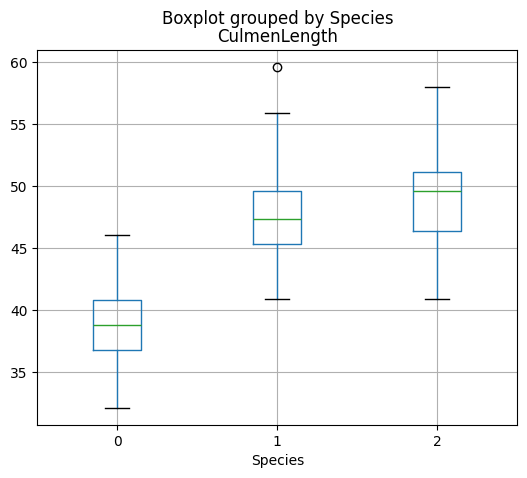

Unique values: 80


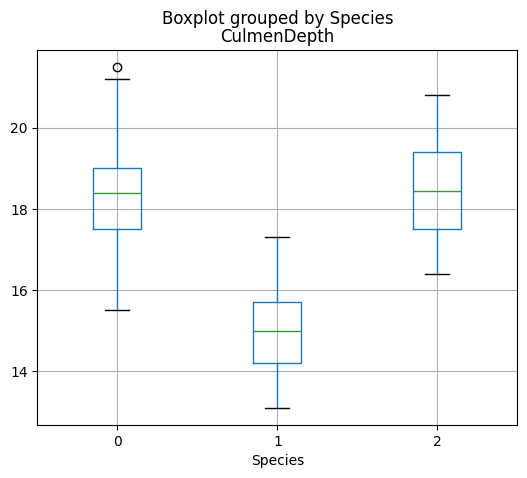

Unique values: 55


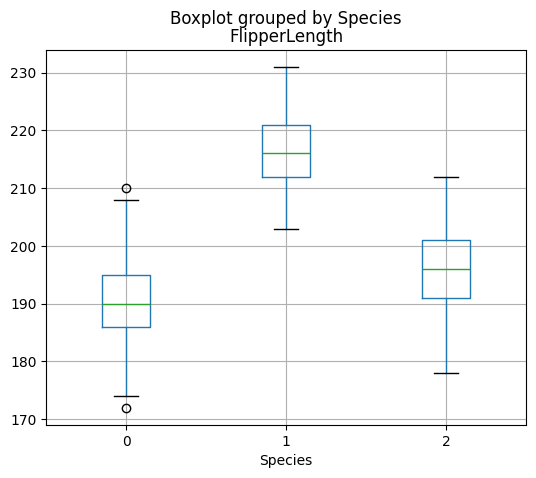

Unique values: 94


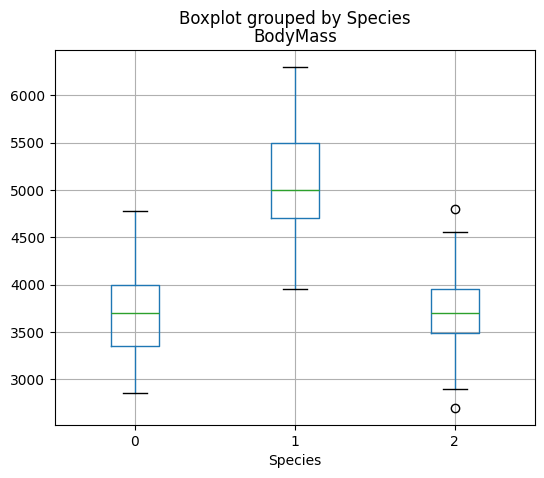

In [4]:
import matplotlib.pyplot as plt
for col in features:
    print(f'Unique values: {len(penguins[col].unique())}')
    penguins.boxplot(column=col, by='Species', figsize=(6,5))
    plt.title(col)
    plt.show()

In [5]:
X, y = penguins[features], penguins[target]
print(X)
print(y)

     CulmenLength  CulmenDepth  FlipperLength  BodyMass
0            39.1         18.7          181.0    3750.0
1            39.5         17.4          186.0    3800.0
2            40.3         18.0          195.0    3250.0
4            36.7         19.3          193.0    3450.0
5            39.3         20.6          190.0    3650.0
..            ...          ...            ...       ...
339          55.8         19.8          207.0    4000.0
340          43.5         18.1          202.0    3400.0
341          49.6         18.2          193.0    3775.0
342          50.8         19.0          210.0    4100.0
343          50.2         18.7          198.0    3775.0

[342 rows x 4 columns]
0      0
1      0
2      0
4      0
5      0
      ..
339    2
340    2
341    2
342    2
343    2
Name: Species, Length: 342, dtype: int64


In [6]:
X.describe()

,CulmenLength,CulmenDepth,FlipperLength,BodyMass
count,342.000000,342.000000,342.000000,342.000000
mean,43.921930,17.151170,200.915205,4201.754386
std,5.459584,1.974793,14.061714,801.954536
min,32.100000,13.100000,172.000000,2700.000000
25%,39.225000,15.600000,190.000000,3550.000000
50%,44.450000,17.300000,197.000000,4050.000000
75%,48.500000,18.700000,213.000000,4750.000000
max,59.600000,21.500000,231.000000,6300.000000


In [7]:
pd.Series(y).value_counts(normalize=True)

Species
0    0.441520
1    0.359649
2    0.198830
Name: proportion, dtype: float64

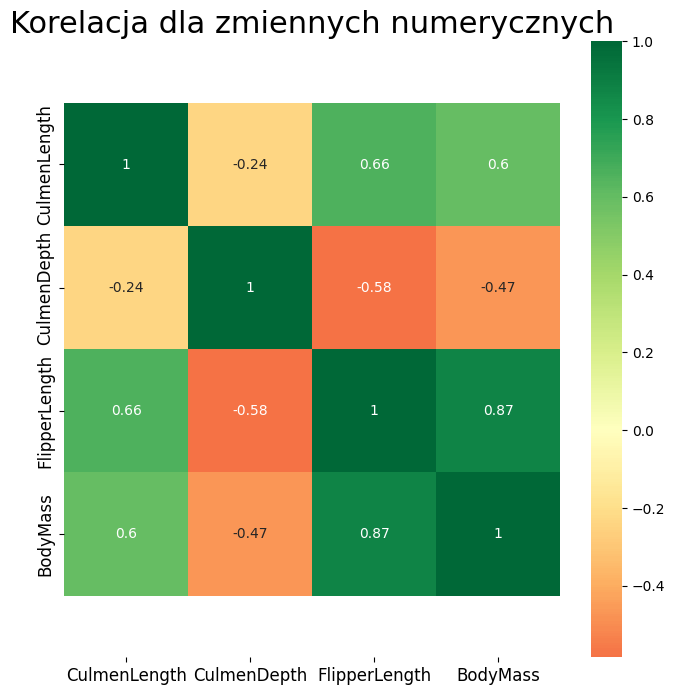

In [8]:
import seaborn as sns
plt.figure(figsize=(8, 8))
ax = sns.heatmap(X.corr(),
                 xticklabels=X.corr().columns,
                 yticklabels=X.corr().columns,
                 cmap='RdYlGn',
                 center=0,
                 annot=True)

plt.title('Korelacja dla zmiennych numerycznych', fontsize=22)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [9]:
from scipy import stats

corr_dict = {}
for col in features:
    corr_dict[col] = stats.pointbiserialr(X[col], y)[0]
pd.Series(corr_dict).sort_values(ascending=False)

CulmenLength     0.779857
FlipperLength    0.357472
BodyMass         0.209717
CulmenDepth     -0.183090
dtype: float64

CulmenLength jest najważniejszą cechą dla modelu. Ze względu na wysoką korelację z target variable, można by podejrzewać data leakage, lecz w tym wypadku raczej nie ma to miejsca (pingwiny nie decydują o swoim dziobie ze względu na wiedzę, do jakiego gatunku przynależą!) Ponadto, jest to cecha, która jest niesamowicie zależna od innych cech. Jednakże, jako jedyna z cech wykrywa znaczące różnice między gatunkiem 0 a gatunkiem 2, więc można ją uznać za krytyczną dla modelu.

FlipperLength jest bardzo zależne od BodyMass. Obie cechy są nam zdecydowanie niepotrzebne, gdyż przekazują mniej więcej te same informacje, a ponieważ FlipperLength ma większą korelację z innymi cechami niż BodyMass, podejmujemy decyzję o usunięciu tej cechy.

CulmenDepth jest najmniej ważną cechą dla naszego modelu pod względem korelacji z target variable, lecz nie ma aż tak wysokiej korelacji z innymi cechami (może poza FlipperLength, które zostało usunięte), więc może wnosić ważne informacje.

In [10]:
X = X.drop('FlipperLength', axis=1)

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_standardized = scaler.fit_transform(X_train)
X_test_standardized = scaler.transform(X_test)

In [12]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report

In [13]:
logistic_reg = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=42)
logistic_reg.fit(X_train_standardized, y_train)
y_pred_logistic = logistic_reg.predict(X_test_standardized)

print("Logistic Regression:\n", classification_report(y_test, y_pred_logistic))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_logistic))

Logistic Regression:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        30
           1       1.00      1.00      1.00        25
           2       1.00      1.00      1.00        14

    accuracy                           1.00        69
   macro avg       1.00      1.00      1.00        69
weighted avg       1.00      1.00      1.00        69

Confusion Matrix:
 [[30  0  0]
 [ 0 25  0]
 [ 0  0 14]]


C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [14]:
decision_tree = DecisionTreeClassifier(max_depth=3, random_state=42)
decision_tree.fit(X_train, y_train)
y_pred_tree = decision_tree.predict(X_test)

print("Decision Tree:\n", classification_report(y_test, y_pred_tree))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_tree))

Decision Tree:
               precision    recall  f1-score   support

           0       1.00      0.93      0.97        30
           1       1.00      1.00      1.00        25
           2       0.88      1.00      0.93        14

    accuracy                           0.97        69
   macro avg       0.96      0.98      0.97        69
weighted avg       0.97      0.97      0.97        69

Confusion Matrix:
 [[28  0  2]
 [ 0 25  0]
 [ 0  0 14]]


In [15]:
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest.fit(X_train, y_train)
y_pred_rf = random_forest.predict(X_test)

print("Random Forest:\n", classification_report(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))

Random Forest:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97        30
           1       1.00      1.00      1.00        25
           2       0.93      0.93      0.93        14

    accuracy                           0.97        69
   macro avg       0.97      0.97      0.97        69
weighted avg       0.97      0.97      0.97        69

Confusion Matrix:
 [[29  0  1]
 [ 0 25  0]
 [ 1  0 13]]


In [16]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_standardized, y_train)
y_pred_knn = knn.predict(X_test_standardized)

print("KNN:\n", classification_report(y_test, y_pred_knn))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_knn))

KNN:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98        30
           1       1.00      1.00      1.00        25
           2       1.00      0.93      0.96        14

    accuracy                           0.99        69
   macro avg       0.99      0.98      0.98        69
weighted avg       0.99      0.99      0.99        69

Confusion Matrix:
 [[30  0  0]
 [ 0 25  0]
 [ 1  0 13]]


In [17]:
svm = SVC(kernel='rbf', probability=True, random_state=42)
svm.fit(X_train_standardized, y_train)
y_pred_svm = svm.predict(X_test_standardized)

print("SVM:\n", classification_report(y_test, y_pred_svm))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_svm))

SVM:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97        30
           1       1.00      1.00      1.00        25
           2       1.00      0.86      0.92        14

    accuracy                           0.97        69
   macro avg       0.98      0.95      0.96        69
weighted avg       0.97      0.97      0.97        69

Confusion Matrix:
 [[30  0  0]
 [ 0 25  0]
 [ 2  0 12]]


In [18]:
adaboost = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3), n_estimators=50, random_state=42)
adaboost.fit(X_train, y_train)
y_pred_adaboost = adaboost.predict(X_test)

print("AdaBoost:\n", classification_report(y_test, y_pred_adaboost))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_adaboost))

AdaBoost:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97        30
           1       1.00      1.00      1.00        25
           2       0.93      0.93      0.93        14

    accuracy                           0.97        69
   macro avg       0.97      0.97      0.97        69
weighted avg       0.97      0.97      0.97        69

Confusion Matrix:
 [[29  0  1]
 [ 0 25  0]
 [ 1  0 13]]


C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Otrzymaliśmy niesamowicie wysokie wyniki dla wszystkich modeli na podstawie naszych danych. Choć nie pokazałam tutaj wyników, sprawdziłam też, jak modele radzą sobie bez cechy CulmenLength - wyniki były zdecydowanie gorsze.